# How do the point source fringes of a point source observation change in different positions on the detector?
We have seen that the transmission peaks of extended source light, seen through an etalon, seen through a pinhole, do not move in wavelength. The transmission peaks also have the same broadening as the extended source light seen only through the etalon (no pinhole). The analysis of the beating fringe in the etalon data (beating related to detector interference) did not display a clear shift either. Though the exercise was limited to a single point source etalon pointing, as far as we know, the fringes of an extended source seen through a pinhole (no etalon) should not vary significantly across the detector. Let us examine this conjecture.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# import modules
import funcs
import mrsobs

import numpy as np
from matplotlib import pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

We load the images for one band of the MRS for different kinds of sources, including: 
* MTS 800K BB extended source
* MTS 800K BB extended source observed through etalon "ET1A"
* MTS 800K BB extended source, observed through etalon "ET1A", observed through pinhole of 100um diameter.
* MTS 800K BB extended source observed through 100micron pinhole
  
Additionally the pixel-to-wavelength calibration map, the MRS spectral resolution table, and the pixel-to-along-slice position map are imported.

In [3]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'

# Get data
band = '1A'
ext_source_sci,ext_source_bkg               = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='800K')
ext_etal_source_sci,ext_etal_source_bkg     = mrsobs.FM_MTS_800K_BB_extended_source_through_etalon(lvl2path,band,etalon='ET1A')
point_etal_source_sci,point_etal_source_bkg = mrsobs.FM_MTS_800K_BB_extended_source_through_etalon_through_pinhole(lvl2path,band,etalon='ET1A')
point_source_sci_p1,point_source_bkg_p1     = mrsobs.FM_MTS_800K_BB_MRS_OPT_06_raster(lvl2path,position='middle',pointing='P1')

# Get wavelength calibration pixel map
d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
lambdaMap = d2cMaps['lambdaMap']
alphaMap = d2cMaps['alphaMap']
nslices   = d2cMaps['nslices']

# Get spectral resolution table
specres_table = funcs.get_cdps(cdpDir=cdpDir,band=band)[4]

We subtract background exposures where available.

In [4]:
# perform transform
ext_source_bkgsubtr        = ext_source_sci-ext_source_bkg
ext_etal_source_bkgsubtr   = ext_etal_source_sci-ext_etal_source_bkg
point_etal_source_bkgsubtr = point_etal_source_sci#-point_etal_source_bkg
point_source_p1_bkgsubtr   = point_source_sci_p1-point_source_bkg_p1

We perform an even-odd row signal correction to the data (caused by the read-out pattern of MIRI detector pixel rows).

In [5]:
ext_source_oddevencorr        = funcs.OddEvenRowSignalCorrection(ext_source_bkgsubtr)
ext_etal_source_oddevencorr   = funcs.OddEvenRowSignalCorrection(ext_etal_source_bkgsubtr)
point_etal_source_oddevencorr = funcs.OddEvenRowSignalCorrection(point_etal_source_bkgsubtr)
point_source_p1_oddevencorr   = funcs.OddEvenRowSignalCorrection(point_source_p1_bkgsubtr)

Let us find the centroid position of a point source in the raster scan dataset closest to the point source etalon data.
  
Note: rather than finding the position of a source in a slice via the pixel of maximum signal, we perform a 1D Guassian fitting to the spatial profile of the source in a slice. This is done on a reconstructed spectral grid. The spectral width of a grid cell ("bin") is proportional to the spectral resolution of the MRS.

Let's construct the spectral grid; the output is one central wavelength and one full-width at half-maximum value in spectral direction, for every cell in the grid.

In [6]:
lambcens,lambfwhms = funcs.spectral_gridding(band,d2cMaps,specres_table=specres_table)

Having constructed the spectral grid, we now determine the centroid of the observed point source in every cell of the grid.  
There are two steps to the centroiding process here:  
* step 1: the detector slice with the largest contained flux is found, this gives a rough idea of the source centroid in across-slice direction, since every slice on the detector has a specific location in the MRS field of view (FOV)  
* step 2: a 1D gaussian fitting is performed to the signal contained in the slice found in step 1; this effectively yields the spatial position of the peak in the MRS PSF and the spatial distribution of the source  
* optional step 3 (not done here): a 2D gaussian fitting is performed to the signal contained in one spectral bin, covering all slices on the detector (you could imagine doing a PSF fitting here)  
  
The final output is the slice number containing the source center, the PSF peak signal of the source in every bin, its along-slice location in the FOV, the standard deviation of the spatial measurement, the fitted PSF continuum (constant background)

In [7]:
pointetalon_centroid = funcs.point_source_along_slice_centroiding(point_etal_source_oddevencorr,band,d2cMaps,spec_grid=[lambcens,lambfwhms],offset_slice=0)
pointsourceraster_centroid = funcs.point_source_along_slice_centroiding(point_source_p1_oddevencorr,band,d2cMaps,spec_grid=[lambcens,lambfwhms],offset_slice=0)

print 'There is a {} slice separation between the two sources'.format(pointetalon_centroid[0]-pointsourceraster_centroid[0])

There is a 3 slice separation between the two sources


Let's look at the result.

<IPython.core.display.Javascript object>


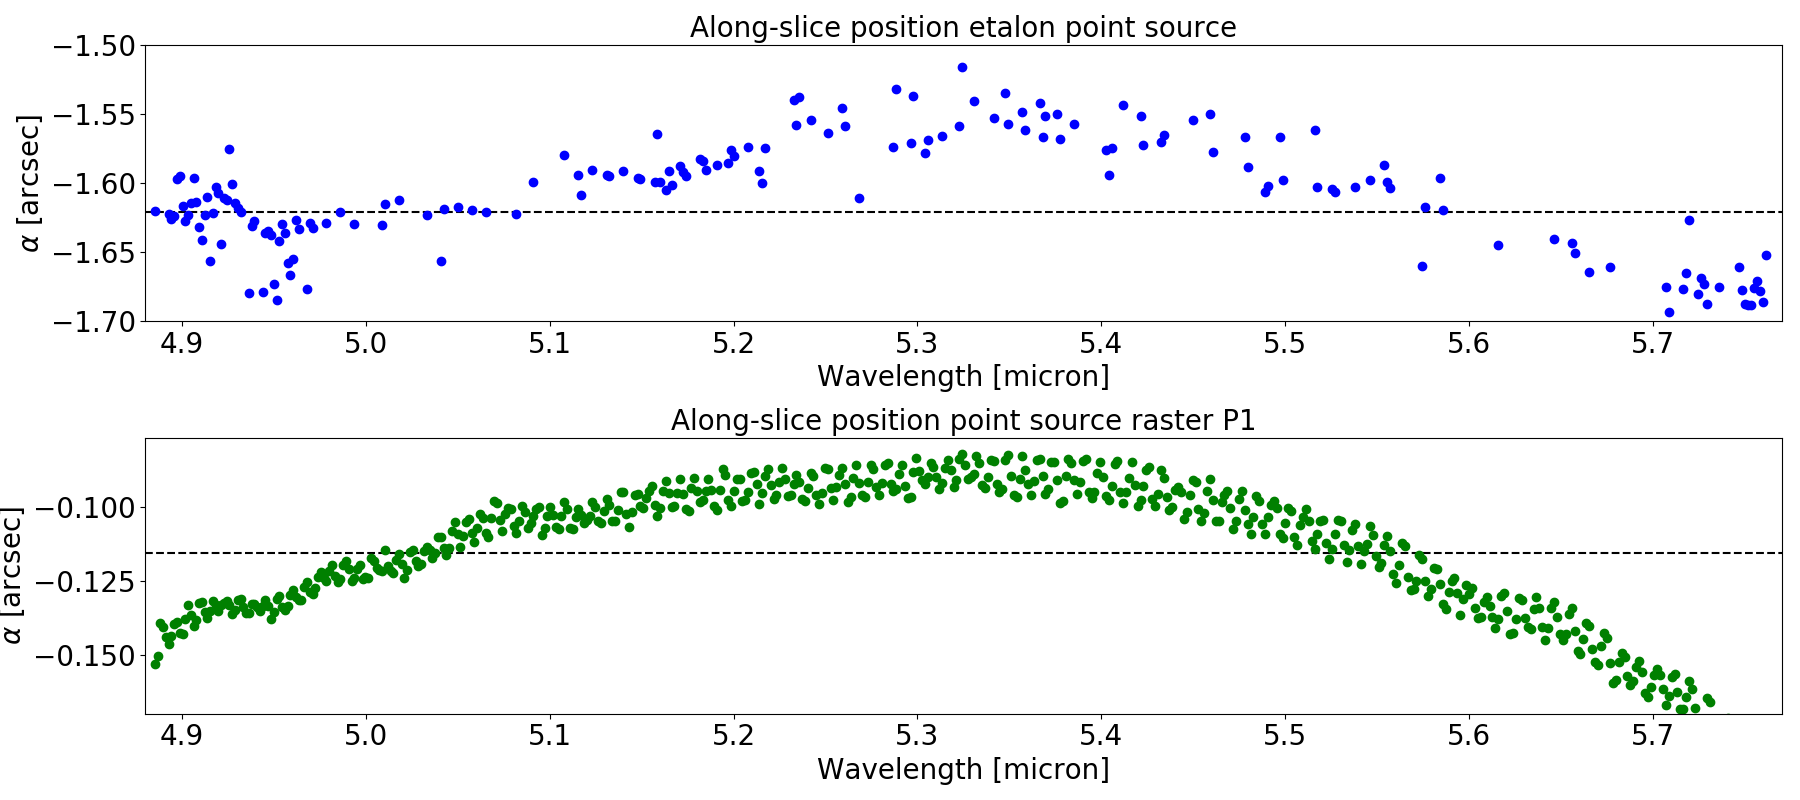

In [8]:
fig,axs = plt.subplots(2,1,figsize=(18,8))
axs[0].plot(lambcens,pointetalon_centroid[2],'bo')
axs[0].hlines(np.mean(pointetalon_centroid[2][~np.isnan(pointetalon_centroid[2])]),4.88,5.77,linestyle='dashed')
axs[0].set_ylim(-1.7,-1.5)
axs[0].set_ylabel(r'$\alpha$ [arcsec]')
axs[0].set_title('Along-slice position etalon point source')
axs[1].plot(lambcens,pointsourceraster_centroid[2],'go')
axs[1].hlines(np.mean(pointsourceraster_centroid[2][~np.isnan(pointsourceraster_centroid[2])]),4.88,5.77,linestyle='dashed')
axs[1].set_ylim(-0.17)
axs[1].set_ylabel(r'$\alpha$ [arcsec]')
axs[1].set_title('Along-slice position point source raster P1')
for plot in range(2):
    axs[plot].set_xlim(4.88,5.77)
    axs[plot].set_xlabel('Wavelength [micron]')
plt.tight_layout()

### Remarks:
* The along-slice position of the source varies in a systematic way over the wavelength range. This is a known issue with the along-slice solution of the distortion CDP. The latter was derived by collapsing 3d spectral cubes of point source observations in wavelength direction, and as such the dependency of the along-slice position of point sources versus wavelength was not measured to the greatest detail. This issue is now worked on by Polychronis Patapis (ETH Zurich). 
* The etalon point source is higher on the vertical (in the FOV) compared to the raster test's point source position (this comment relates to the across-slice position).
* The etalon point source is more to the left (in the FOV) compared to the raster test's point source position (this comment relates to the along-slice position).  
  
Next we look at a raster scan observation on the "left" of the MRS FOV, in slice 10.

In [10]:
point_source_sci_p2,point_source_bkg_p2 = mrsobs.FM_MTS_800K_BB_MRS_OPT_06_raster(lvl2path,position='left',pointing='P9')
point_source_p2_bkgsubtr                = point_source_sci_p2-point_source_bkg_p2
point_source_p2_oddevencorr             = funcs.OddEvenRowSignalCorrection(point_source_p2_bkgsubtr)
pointsourceraster_centroid_p2           = funcs.point_source_along_slice_centroiding(point_source_p2_oddevencorr,band,d2cMaps,spec_grid=[lambcens,lambfwhms],offset_slice=0)

Let's look at the result.

<IPython.core.display.Javascript object>


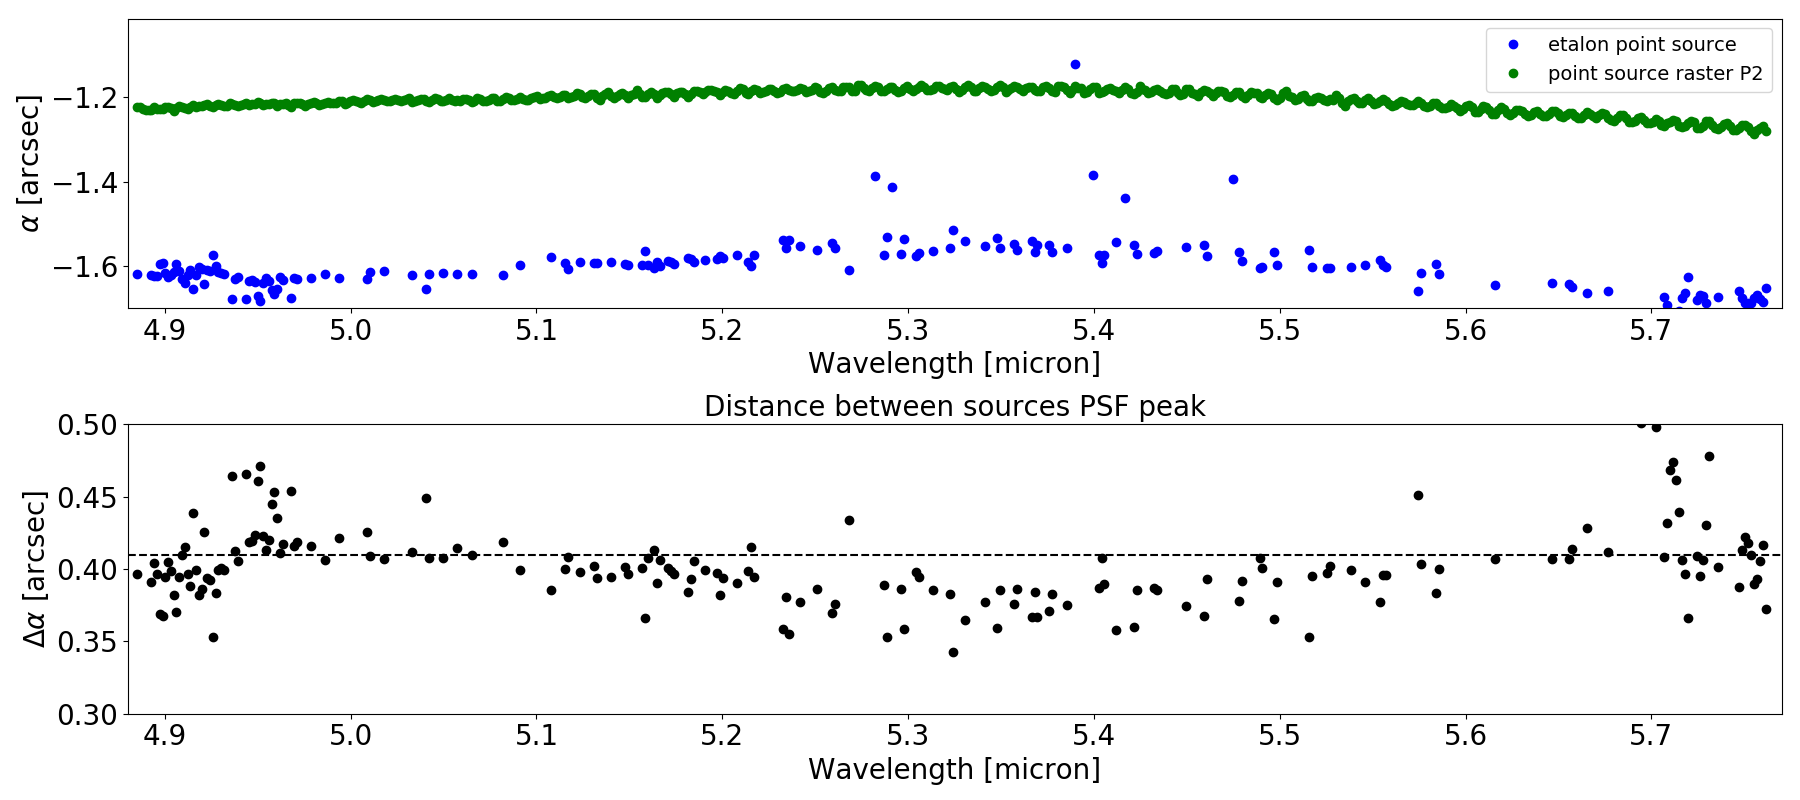

In [11]:
fig,axs = plt.subplots(2,1,figsize=(18,8))
axs[0].plot(lambcens,pointetalon_centroid[2],'bo',label='etalon point source')
axs[0].plot(lambcens,pointsourceraster_centroid_p2[2],'go',label='point source raster P2')
axs[0].set_ylim(-1.7)
axs[0].set_ylabel(r'$\alpha$ [arcsec]')
axs[0].legend(loc='upper right',fontsize=14)
axs[1].plot(lambcens,pointsourceraster_centroid_p2[2]-pointetalon_centroid[2],'ko')
axs[1].hlines(np.mean((pointsourceraster_centroid_p2[2]-pointetalon_centroid[2])[~np.isnan((pointsourceraster_centroid_p2[2]-pointetalon_centroid[2]) )]),4.88,5.77,linestyle='dashed')
axs[1].set_ylim(0.3,0.5)
axs[1].set_ylabel(r'$\Delta \alpha$ [arcsec]')
axs[1].set_title('Distance between sources PSF peak')
for plot in range(2):
    axs[plot].set_xlim(4.88,5.77)
    axs[plot].set_xlabel('Wavelength [micron]')
plt.tight_layout()

### Remarks:
* This is the closest raster scan observation to the etalon point source data. The along-slice distance of 0.4 arcseconds is equivalent to a separation of 2 pixels.  
  
Let us now play with the concepts presented above.

### Test 1: How do the point source fringes change in across-slice direction?

In [ ]:
# centroiding process for the point sources
pointsource_leftraster_centroids = {}
for pointing in ['P8','P9','P10']:
    point_source_sci_p,point_source_bkg_p       = mrsobs.FM_MTS_800K_BB_MRS_OPT_06_raster(lvl2path,position='left',pointing=pointing)
    point_source_p_bkgsubtr                     = point_source_sci_p-point_source_bkg_p
    point_source_p_oddevencorr                  = funcs.OddEvenRowSignalCorrection(point_source_p_bkgsubtr)
    pointsource_leftraster_centroids[pointing]  = funcs.point_source_centroiding(point_source_p_oddevencorr,band,d2cMaps,spec_grid=[lambcens,lambfwhms],fit='1D')

<IPython.core.display.Javascript object>


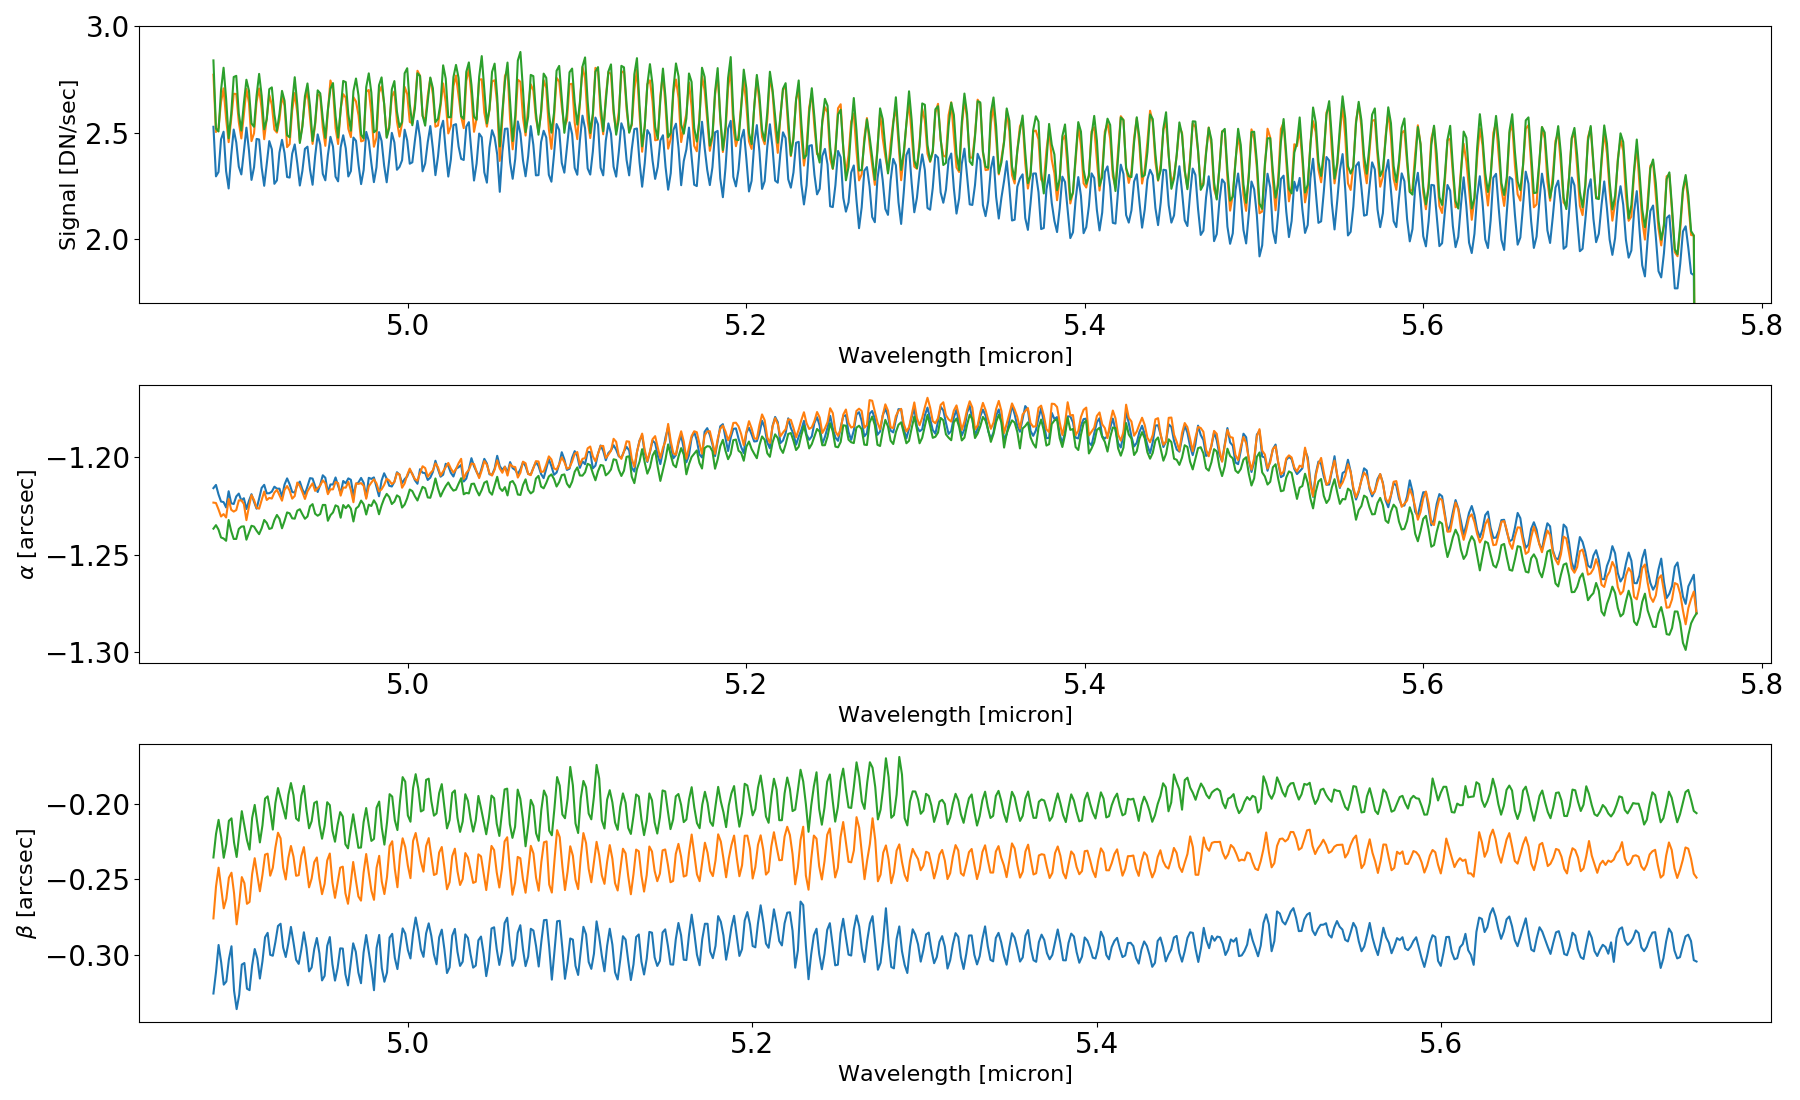

In [13]:
# let's look at the result for the point sources
fig,axs = plt.subplots(3,1,figsize=(18,11))
plot = 0
for pointing in ['P8','P9','P10']:
    axs[0].plot(lambcens,pointsource_leftraster_centroids[pointing][0])
    axs[1].plot(lambcens,pointsource_leftraster_centroids[pointing][1])
    axs[2].plot(lambcens,pointsource_leftraster_centroids[pointing][2])
    axs[plot].set_xlabel('Wavelength [micron]',fontsize=16)
    axs[plot].tick_params(axis='both',labelsize=20)    
    plot+=1
axs[0].set_ylim(1.7,3)
axs[0].set_ylabel(r'Signal [DN/sec]',fontsize=16)
axs[1].set_ylabel(r'$\alpha$ [arcsec]',fontsize=16)
axs[2].set_ylabel(r'$\beta$ [arcsec]',fontsize=16)
plt.tight_layout()

### Remarks:
* Fringes affect the centroid determination at sub-pixel level.  
  
Let's determine the fringe transmission of the point sources.

In [14]:
pointsource_leftraster_norm = {}
for pointing in ['P8','P9','P10']:
    pointsource_leftraster_norm[pointing] = funcs.norm_fringe(pointsource_leftraster_centroids[pointing][0],thres=0,min_dist=2,k=3,ext=3)

<IPython.core.display.Javascript object>


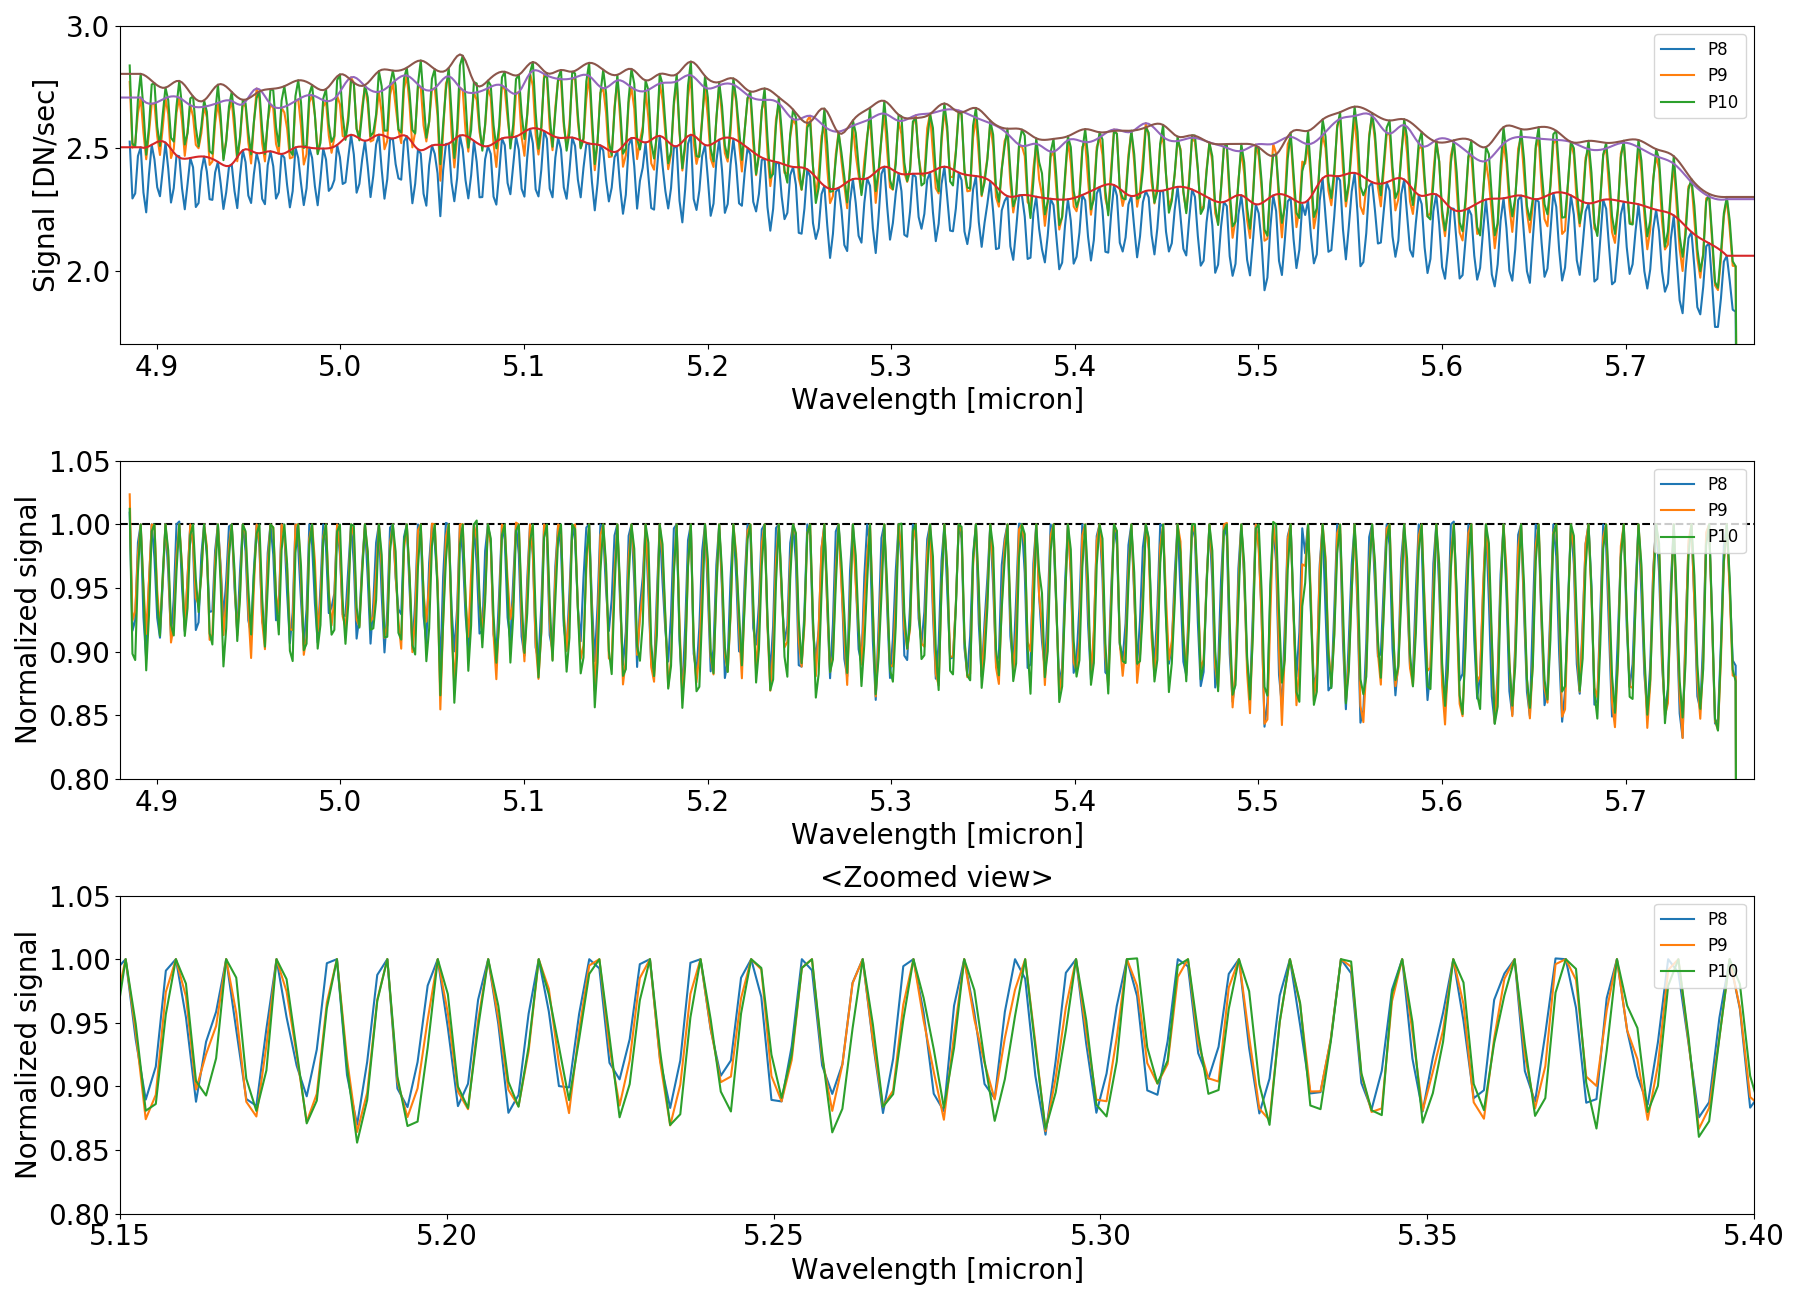

In [15]:
# let's look at the results
fig,axs = plt.subplots(3,1,figsize=(18,13))
for pointing in ['P8','P9','P10']:
    axs[0].plot(lambcens,pointsource_leftraster_centroids[pointing][0],label=pointing)
for pointing in ['P8','P9','P10']:
    axs[0].plot(lambcens,pointsource_leftraster_norm[pointing][2])
    axs[1].plot(lambcens,pointsource_leftraster_centroids[pointing][0]/pointsource_leftraster_norm[pointing][2],label=pointing)
    axs[2].plot(lambcens,pointsource_leftraster_centroids[pointing][0]/pointsource_leftraster_norm[pointing][2],label=pointing)
axs[0].set_ylim(1.7,3)
axs[0].set_ylabel('Signal [DN/sec]')
axs[1].hlines(1,4.88,5.77,linestyle='dashed')
for plot in range(2):
    axs[plot].set_xlim(4.88,5.77)
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].legend(loc='upper right',fontsize=12)
for plot in range(1,3):
    axs[plot].set_ylim(0.8,1.05)
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Normalized signal')
    axs[plot].legend(loc='upper right',fontsize=12)
axs[2].set_xlim(5.15,5.40)
axs[2].set_title('<Zoomed view>')
plt.tight_layout()

### Remarks:
* The fringes look qualitatively similar, but what happens when we take the ratio of the fringes? (ideally the fringes would cancel out)

<IPython.core.display.Javascript object>


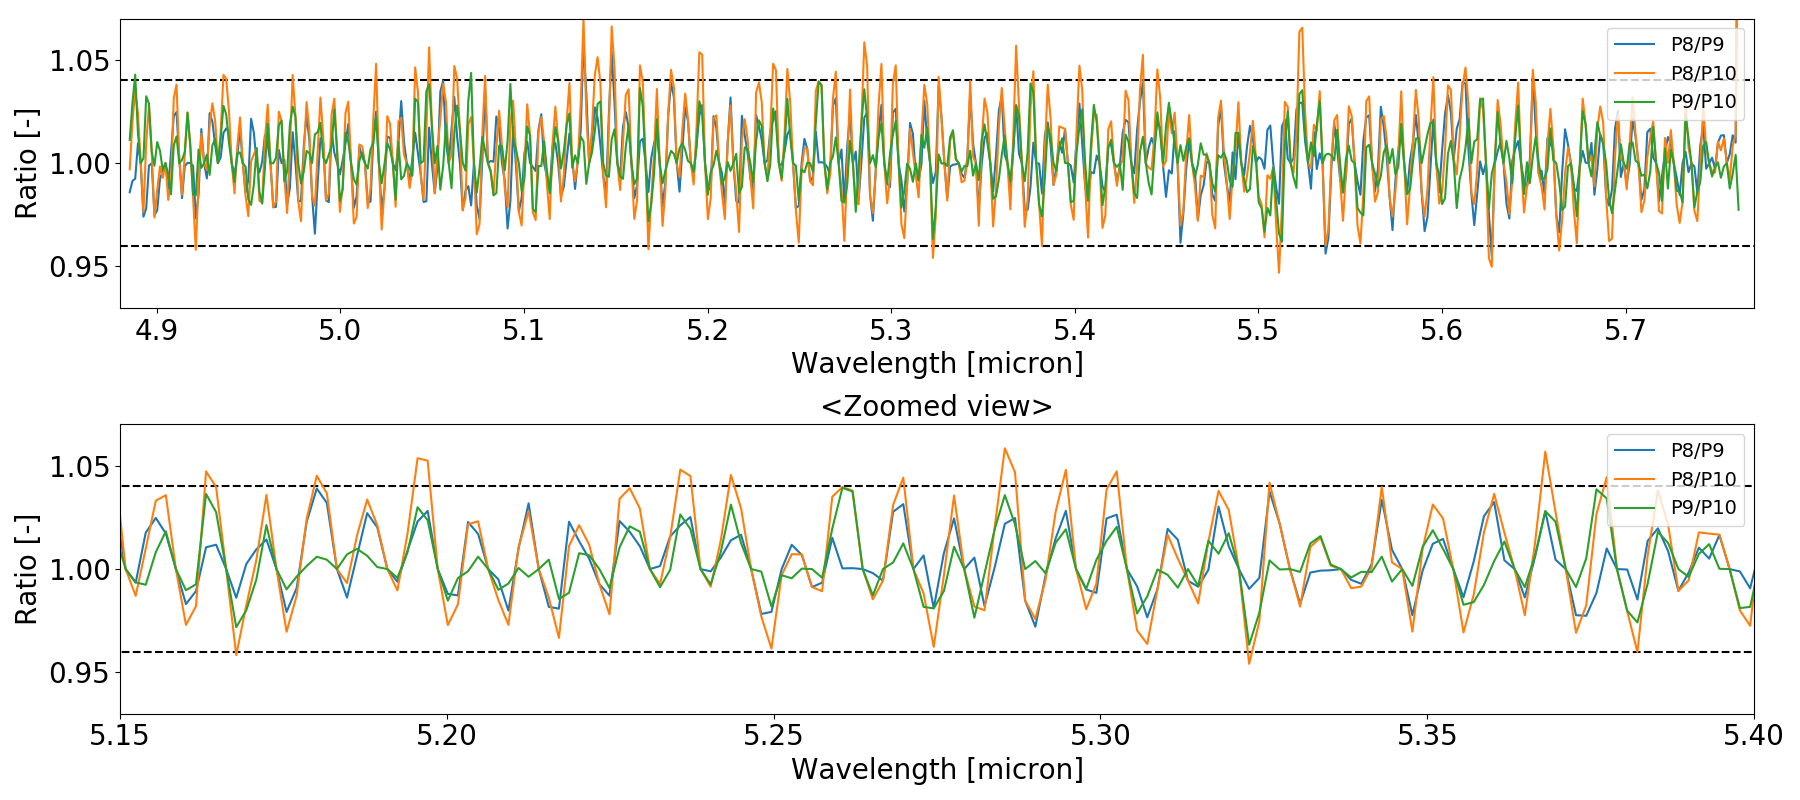

In [17]:
p8 = pointsource_leftraster_centroids['P8'][0]/pointsource_leftraster_norm['P8'][2]
p9 = pointsource_leftraster_centroids['P9'][0]/pointsource_leftraster_norm['P9'][2]
p10 = pointsource_leftraster_centroids['P10'][0]/pointsource_leftraster_norm['P10'][2]

fig,axs = plt.subplots(2,1,figsize=(18,8))
for plot in range(2):
    axs[plot].plot(lambcens,p8/p9,label='P8/P9')
    axs[plot].plot(lambcens,p8/p10,label='P8/P10')
    axs[plot].plot(lambcens,p9/p10,label='P9/P10')
    axs[plot].hlines([0.96,1.04],4.88,5.77,linestyle='dashed')
    axs[plot].set_ylim(0.93,1.07)
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Ratio [-]')
    axs[plot].legend(loc='upper right',fontsize=14)
axs[0].set_xlim(4.88,5.77)
axs[1].set_xlim(5.15,5.40)
axs[1].set_title('<Zoomed view>')
plt.tight_layout()

### Remarks:
* The residuals are periodic.
* The residual peaks overlap for the different ratios.
* The residual peaks change in amplitude depending on the across-slice distance of two pointings. For two distanced pointings (e.g. P8/P10) the residuals are larger than those of two nearby pointings (e.g. P8/P9). The difference is 4% versus 2% for P8/P10 and P8/P9 respectively.
* It is not clear if the residuals of ratio P8/P9 are equal to the residuals of ratio P9/P10.
* We know from Zemax modeling of the MRS that a wavelength correction is required as a function of target across-slice position (MIRI-DD-00006-ATC). Such a correction is not applied here, and thus could explain part of the discrepancy. Looking (much) more closely at the amplitude of the fringe profiles at every pointing however, the amplitude seems to grow larger from P8 to P10. Here we mention in passing another correction envisioned for the MRS calibration pipeline, namely a transmission correction as a function of a target's across-slice position (MIRI-DD-00007-ATC). It is not clear how the fringe transmission could be related to the vignetting issue described in the technical note. Whether the two are related, or not, the cause of the fringe residuals appears (to me) more dependent on the amplitude of the fringing rather than a wavelength offset.

### Test 2: How does the center (P9) point source fringe profile compare to the extended source fringe profile?
Any effect of across-slice transmission / wavelength offset on the comparison between point source and extended source fringes should be mitigated by looking at the center of the slice. So let's do that.

In [18]:
point_source_sci_p9,point_source_bkg_p9 = mrsobs.FM_MTS_800K_BB_MRS_OPT_06_raster(lvl2path,position='left',pointing='P9')
point_source_p9_bkgsubtr                = point_source_sci_p9-point_source_bkg_p9
point_source_p9_oddevencorr             = funcs.OddEvenRowSignalCorrection(point_source_p9_bkgsubtr)
ypos_p9,xpos_p9                         = funcs.detpixel_trace_compactsource(point_source_p9_oddevencorr,band,d2cMaps)

extsource_p9_norm = funcs.norm_fringe(ext_source_oddevencorr[ypos_p9,xpos_p9],thres=0,min_dist=6,k=3,ext=3)

<IPython.core.display.Javascript object>


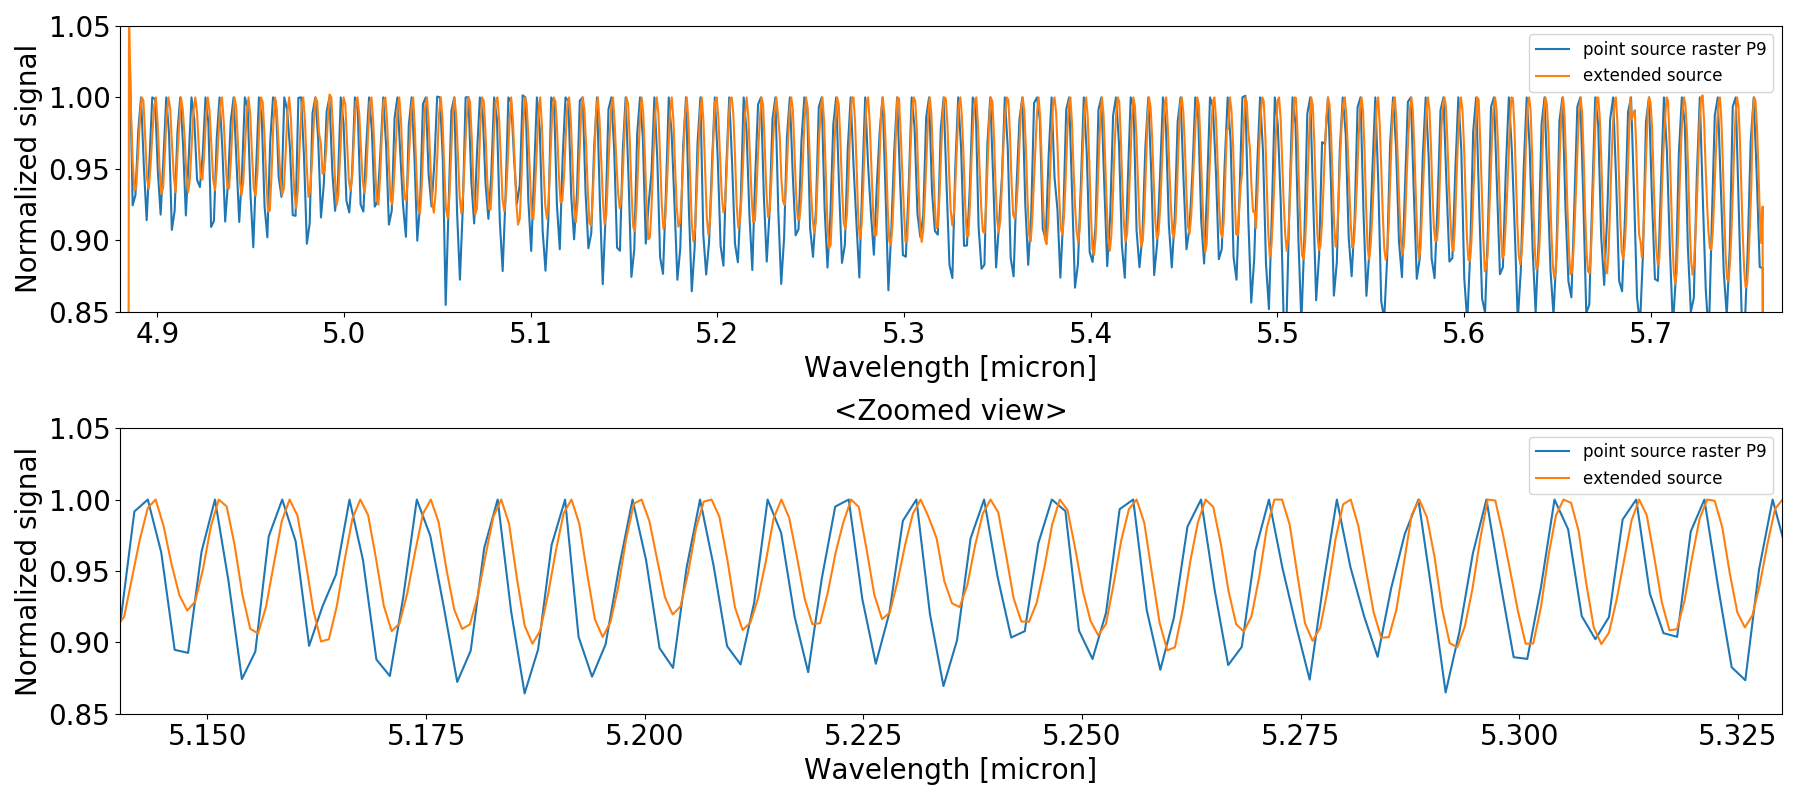

In [19]:
# let's look at the results
fig,axs = plt.subplots(2,1,figsize=(18,8))
for plot in range(2):
    axs[plot].plot(lambcens,p9,label='point source raster P9')
    axs[plot].plot(lambdaMap[ypos_p9,xpos_p9],extsource_p9_norm[0]/extsource_p9_norm[2],label='extended source')
    axs[plot].set_ylim(0.85,1.05)
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Normalized signal')
    axs[plot].legend(loc='upper right',fontsize=12)
axs[0].set_xlim(4.88,5.77)
axs[1].set_xlim(5.14,5.33)
axs[1].set_title('<Zoomed view>')
plt.tight_layout()

### Remarks:
* There is a frequency and/or phase offset between the point source fringe profile and the extended source fringe profile.
* The amplitude of the point source fringes is larger than that of the extended source fringes, however the difference is not constant over the wavelength range (makes more difficult to interpret the underlying cause). The contrast of the extended source fringes **is** expected to be smaller than the contrast of the point source fringes, due to the integration of light over a larger portion of the FOV (uniform slit illumination).

### Test 3: How do the results look in different along-slice positions (left, middle, right part of FOV)?

In [ ]:
# centroiding process for the point sources in the middle of the FOV
pointsource_middleraster_centroids = {}
for pointing in ['P4','P5']:
    point_source_sci_p,point_source_bkg_p        = mrsobs.FM_MTS_800K_BB_MRS_OPT_06_raster(lvl2path,position='middle',pointing=pointing)
    point_source_p_bkgsubtr                      = point_source_sci_p-point_source_bkg_p
    point_source_p_oddevencorr                   = funcs.OddEvenRowSignalCorrection(point_source_p_bkgsubtr)
    pointsource_middleraster_centroids[pointing] = funcs.point_source_centroiding(point_source_p_oddevencorr,band,d2cMaps,spec_grid=[lambcens,lambfwhms],fit='1D')

<IPython.core.display.Javascript object>


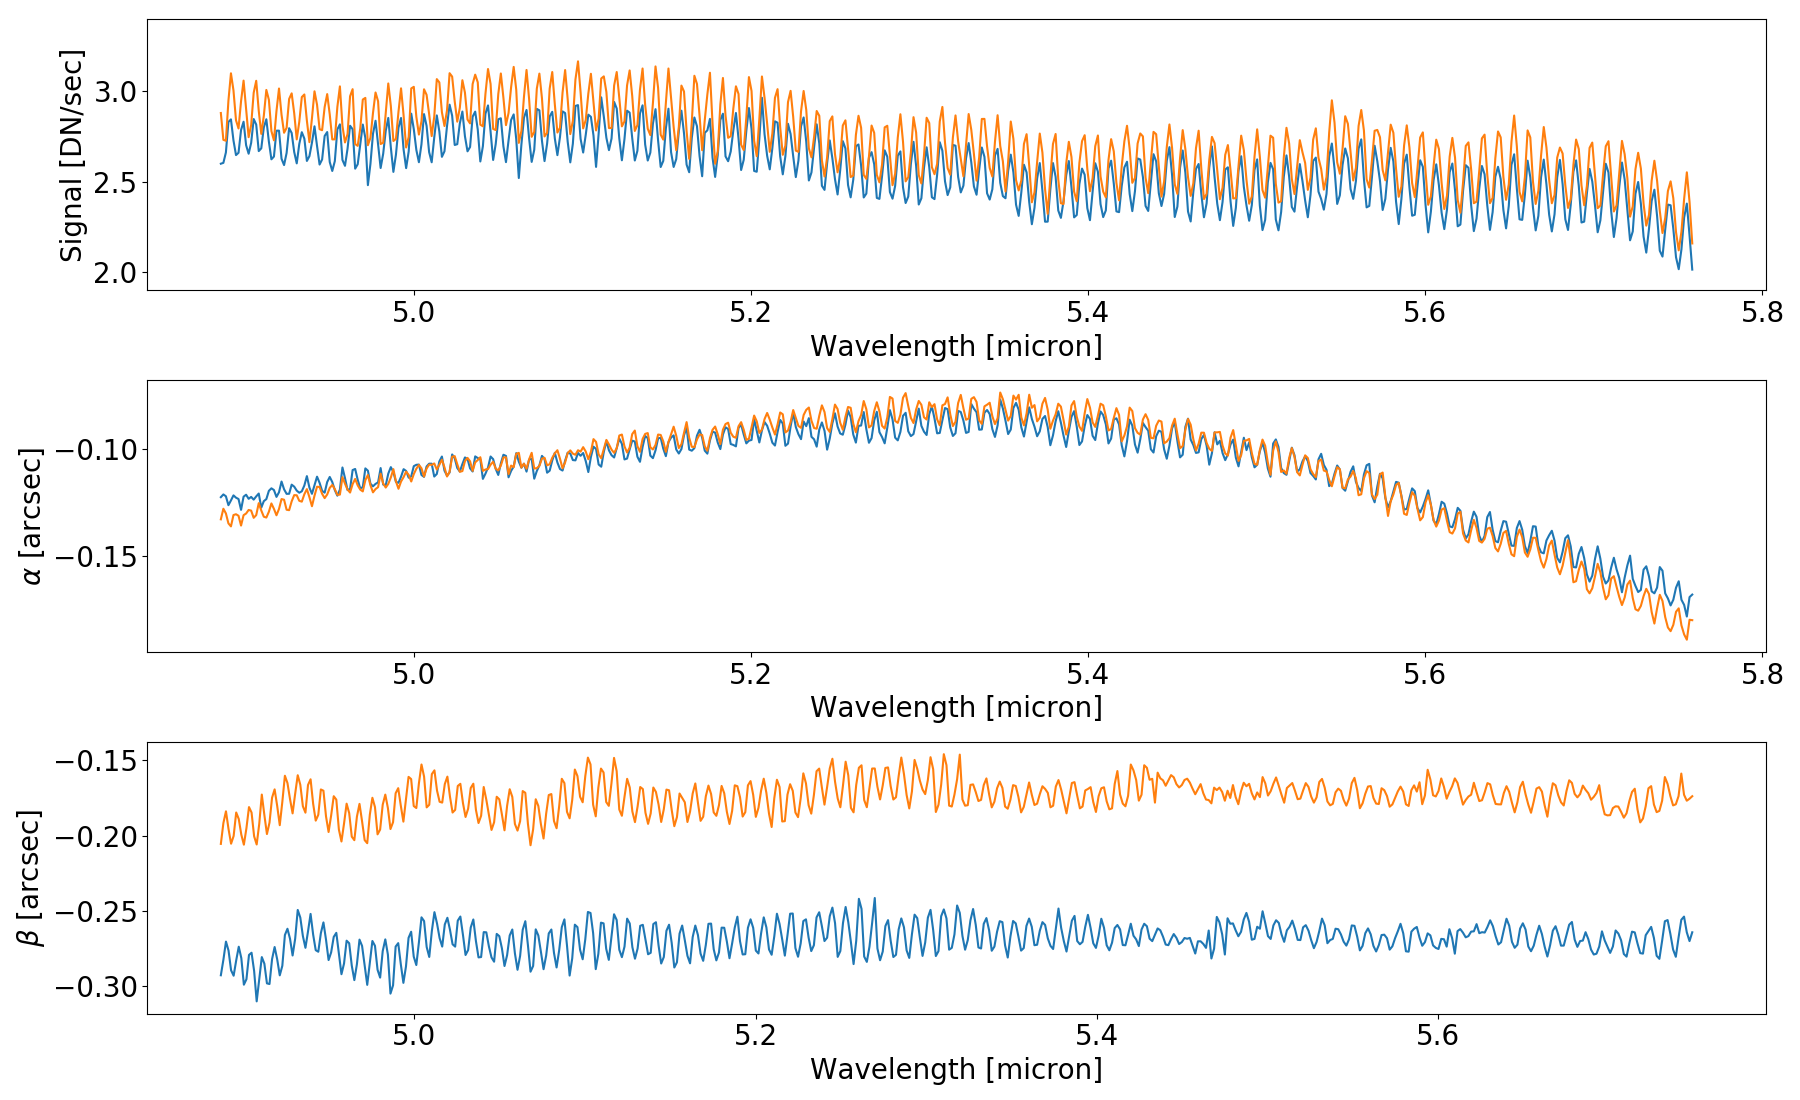

In [27]:
# let's look at the result for the point sources
fig,axs = plt.subplots(3,1,figsize=(18,11))
for pointing in ['P4','P5']:
    axs[0].plot(lambcens,pointsource_middleraster_centroids[pointing][0])
    axs[1].plot(lambcens,pointsource_middleraster_centroids[pointing][1])
    axs[2].plot(lambcens,pointsource_middleraster_centroids[pointing][2])
for plot in range(3):
    axs[plot].set_xlabel('Wavelength [micron]')   
axs[0].set_ylim(1.9,3.4)
axs[0].set_ylabel(r'Signal [DN/sec]')
axs[1].set_ylabel(r'$\alpha$ [arcsec]')
axs[2].set_ylabel(r'$\beta$ [arcsec]')
plt.tight_layout()

In [28]:
pointsource_middleraster_norm = {}
for pointing in ['P4','P5']:
    pointsource_middleraster_norm[pointing] = funcs.norm_fringe(pointsource_middleraster_centroids[pointing][0],thres=0,min_dist=2,k=3,ext=3)

<IPython.core.display.Javascript object>


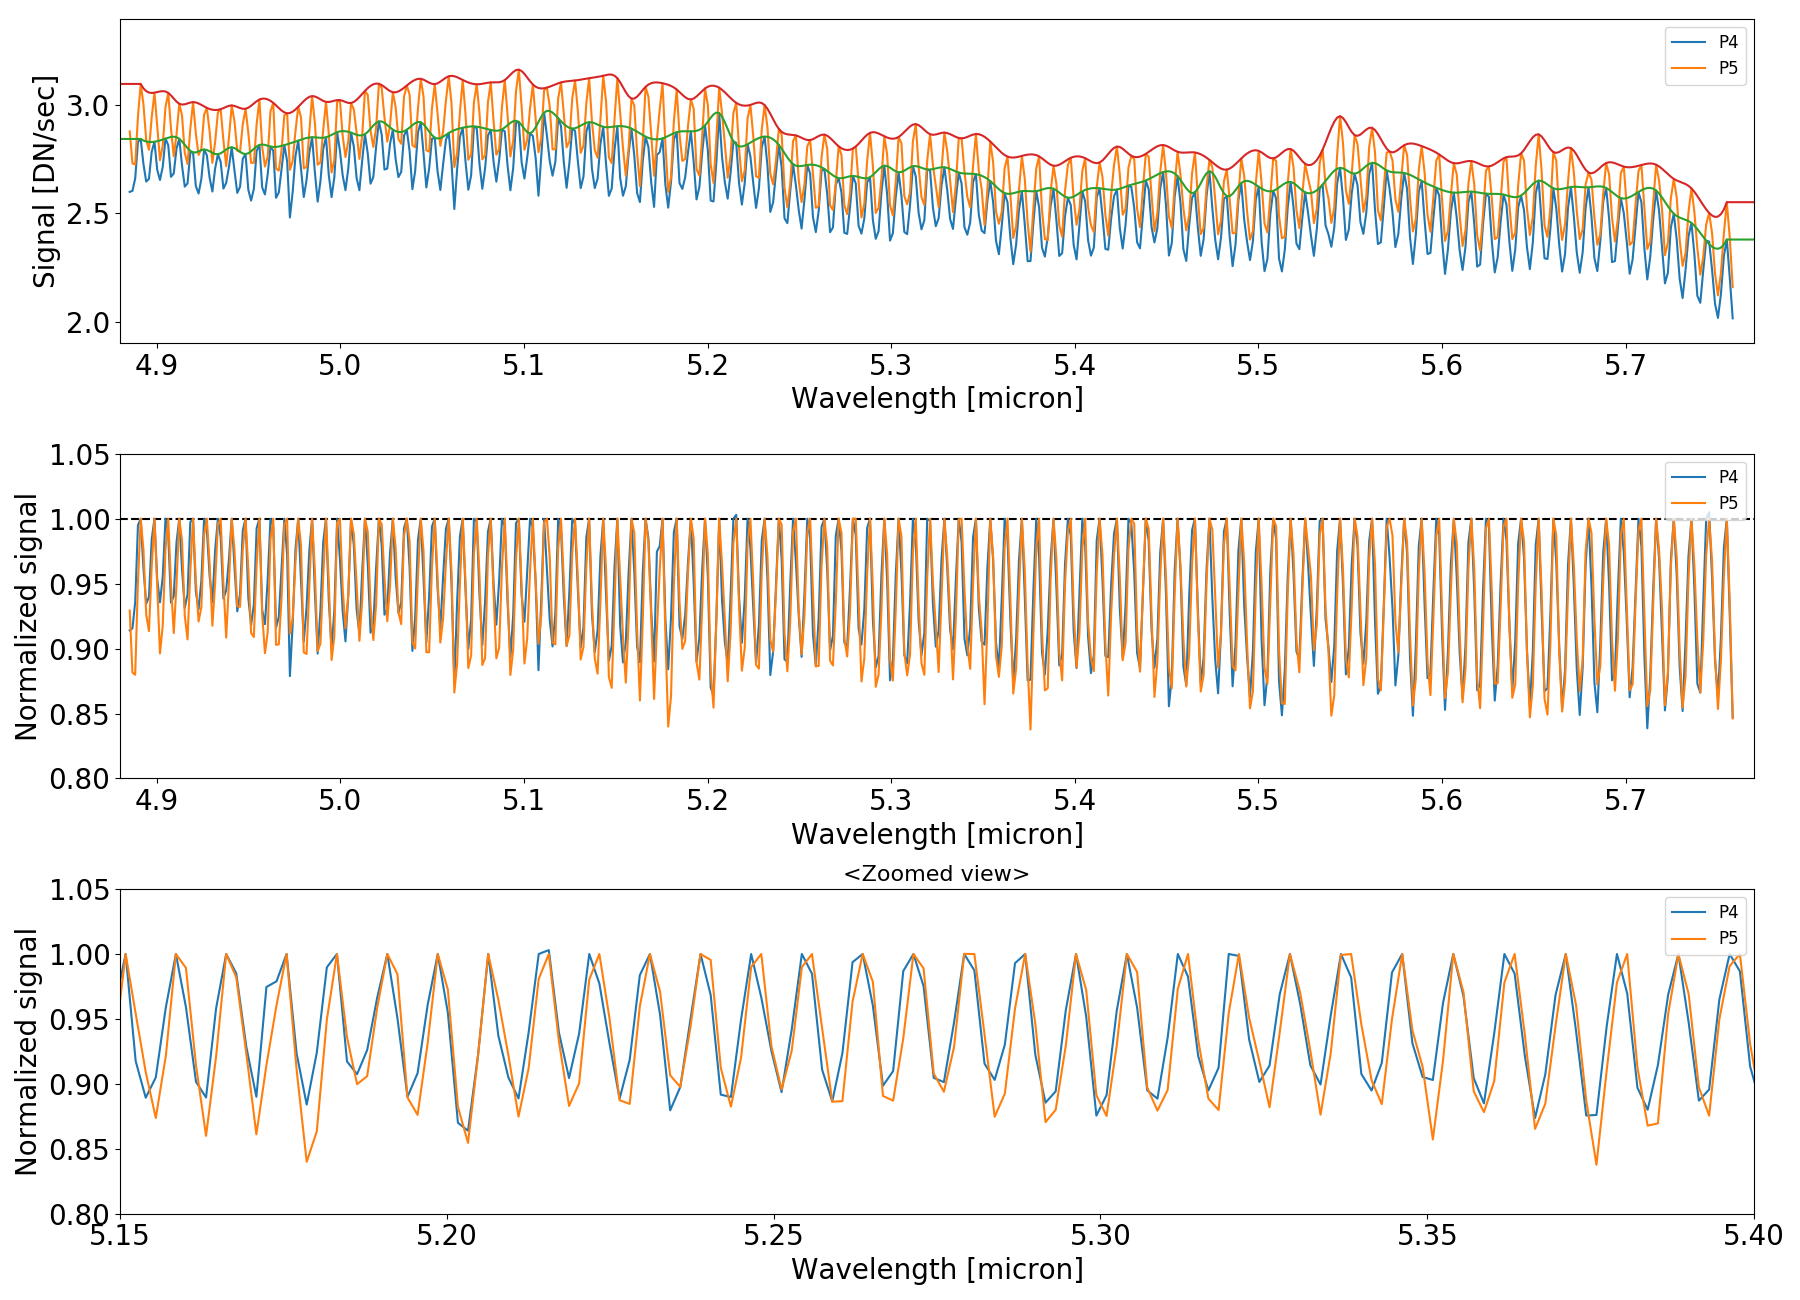

In [29]:
# let's look at the results
fig,axs = plt.subplots(3,1,figsize=(18,13))
for pointing in ['P4','P5']:
    axs[0].plot(lambcens,pointsource_middleraster_centroids[pointing][0],label=pointing)
for pointing in ['P4','P5']:
    axs[0].plot(lambcens,pointsource_middleraster_norm[pointing][2])
    axs[1].plot(lambcens,pointsource_middleraster_centroids[pointing][0]/pointsource_middleraster_norm[pointing][2],label=pointing)
    axs[2].plot(lambcens,pointsource_middleraster_centroids[pointing][0]/pointsource_middleraster_norm[pointing][2],label=pointing)
axs[0].set_ylim(1.9,3.4)
axs[0].set_ylabel('Signal [DN/sec]')
axs[1].hlines(1,4.88,5.77,linestyle='dashed')
for plot in range(2):
    axs[plot].set_xlim(4.88,5.77)
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].legend(loc='upper right',fontsize=12)
for plot in range(1,3):
    axs[plot].set_ylim(0.8,1.05)
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Normalized signal')
    axs[plot].legend(loc='upper right',fontsize=12)
axs[2].set_xlim(5.15,5.40)
axs[2].set_title('<Zoomed view>',fontsize=16)
plt.tight_layout()

<IPython.core.display.Javascript object>


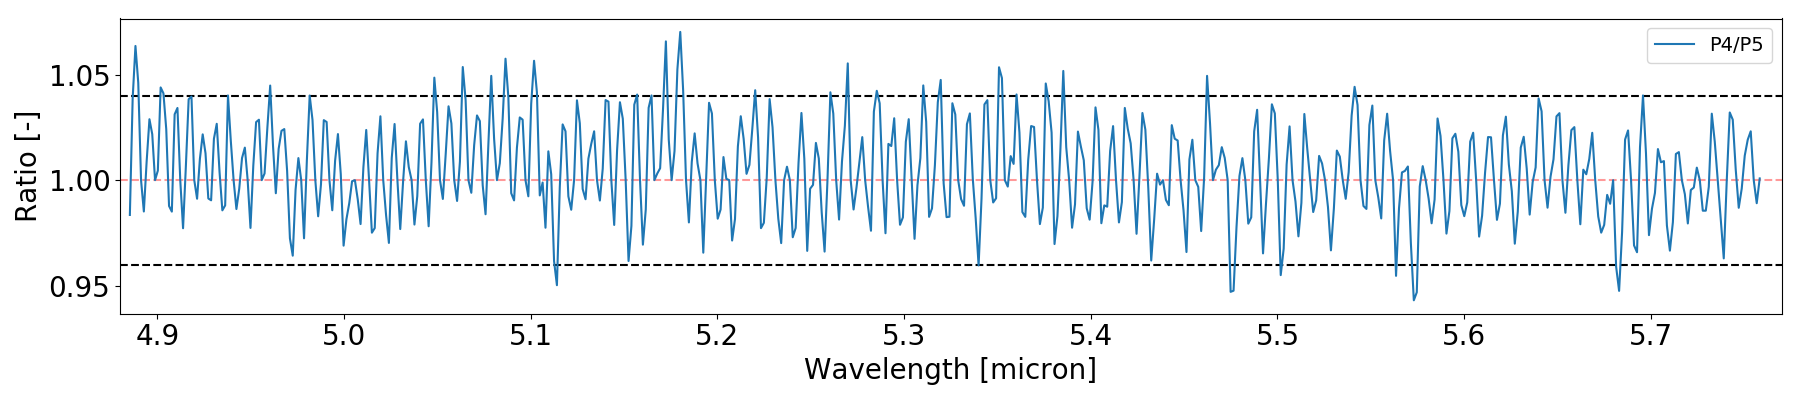

In [30]:
p4 = pointsource_middleraster_centroids['P4'][0]/pointsource_middleraster_norm['P4'][2]
p5 = pointsource_middleraster_centroids['P5'][0]/pointsource_middleraster_norm['P5'][2]

plt.figure(figsize=(18,4))
plt.plot(lambcens,p4/p5,label='P4/P5')
plt.hlines([0.96,1.04],4.88,5.77,linestyle='dashed')
plt.hlines(1,4.88,5.77,'r',alpha=0.4,linestyle='dashed')
plt.xlim(4.88,5.77)
plt.xlabel('Wavelength [micron]')
plt.ylabel('Ratio [-]')
plt.legend(loc='upper right',fontsize=14)
plt.tight_layout()

### Remarks:
* The across-slice distance between P4 and P5 is similar, though slightly smaller than P8 to P10. The residuals seem to be of the same order, around 4%.  
  
Let's compare P4 to the extended source (the result is the same with P5).

In [31]:
point_source_sci_p4,point_source_bkg_p4 = mrsobs.FM_MTS_800K_BB_MRS_OPT_06_raster(lvl2path,position='middle',pointing='P4')
point_source_p4_bkgsubtr                = point_source_sci_p4-point_source_bkg_p4
point_source_p4_oddevencorr             = funcs.OddEvenRowSignalCorrection(point_source_p4_bkgsubtr)
ypos_p4,xpos_p4                         = funcs.detpixel_trace_compactsource(point_source_p4_oddevencorr,band,d2cMaps)

extsource_p4_norm = funcs.norm_fringe(ext_source_oddevencorr[ypos_p4,xpos_p4],thres=0,min_dist=6,k=3,ext=3)

<IPython.core.display.Javascript object>


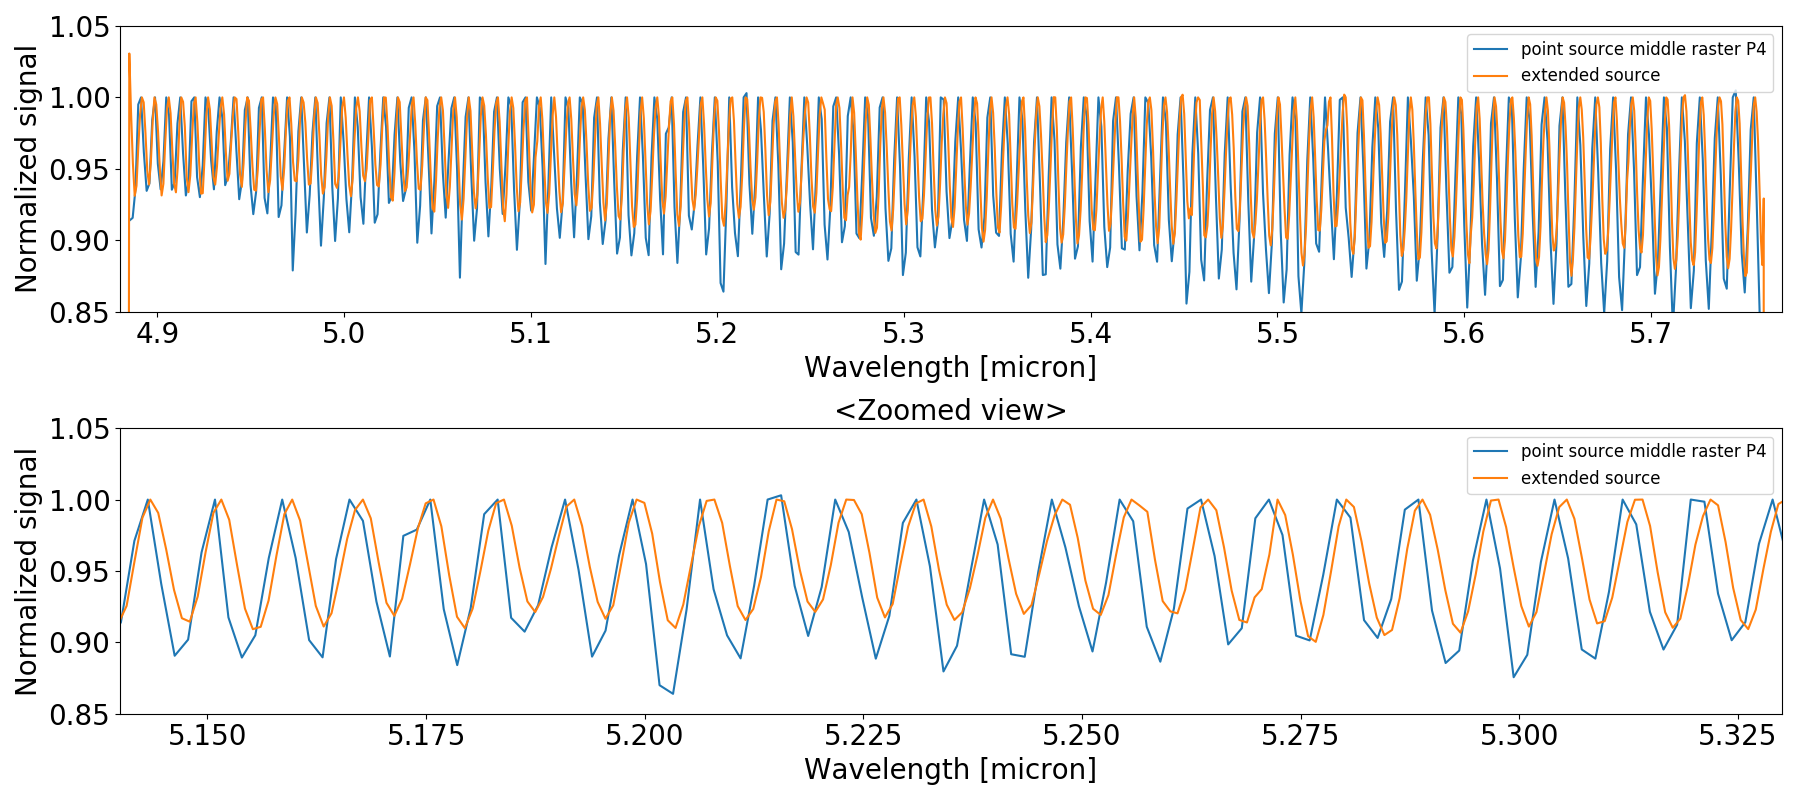

In [32]:
# let's look at the results
fig,axs = plt.subplots(2,1,figsize=(18,8))
for plot in range(2):
    axs[plot].plot(lambcens,p4,label='point source middle raster P4')
    axs[plot].plot(lambdaMap[ypos_p4,xpos_p4],extsource_p4_norm[0]/extsource_p4_norm[2],label='extended source')
    axs[plot].set_ylim(0.85,1.05)
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Normalized signal')
    axs[plot].legend(loc='upper right',fontsize=12)
axs[0].set_xlim(4.88,5.77)
axs[1].set_xlim(5.14,5.33)
axs[1].set_title('<Zoomed view>')
plt.tight_layout()

### Remarks:
* Outcome of middle of FOV analysis is similar to left of FOV. 
* There is a frequency and/or phase shift between the point source and extended source (seemingly in the same direction as for the previous case).
* The locations of different amplitude are not the same sa before.
  
Let's quickly compare the fringe profiles of all the point source positions observed so far (left and middle of FOV).

<IPython.core.display.Javascript object>


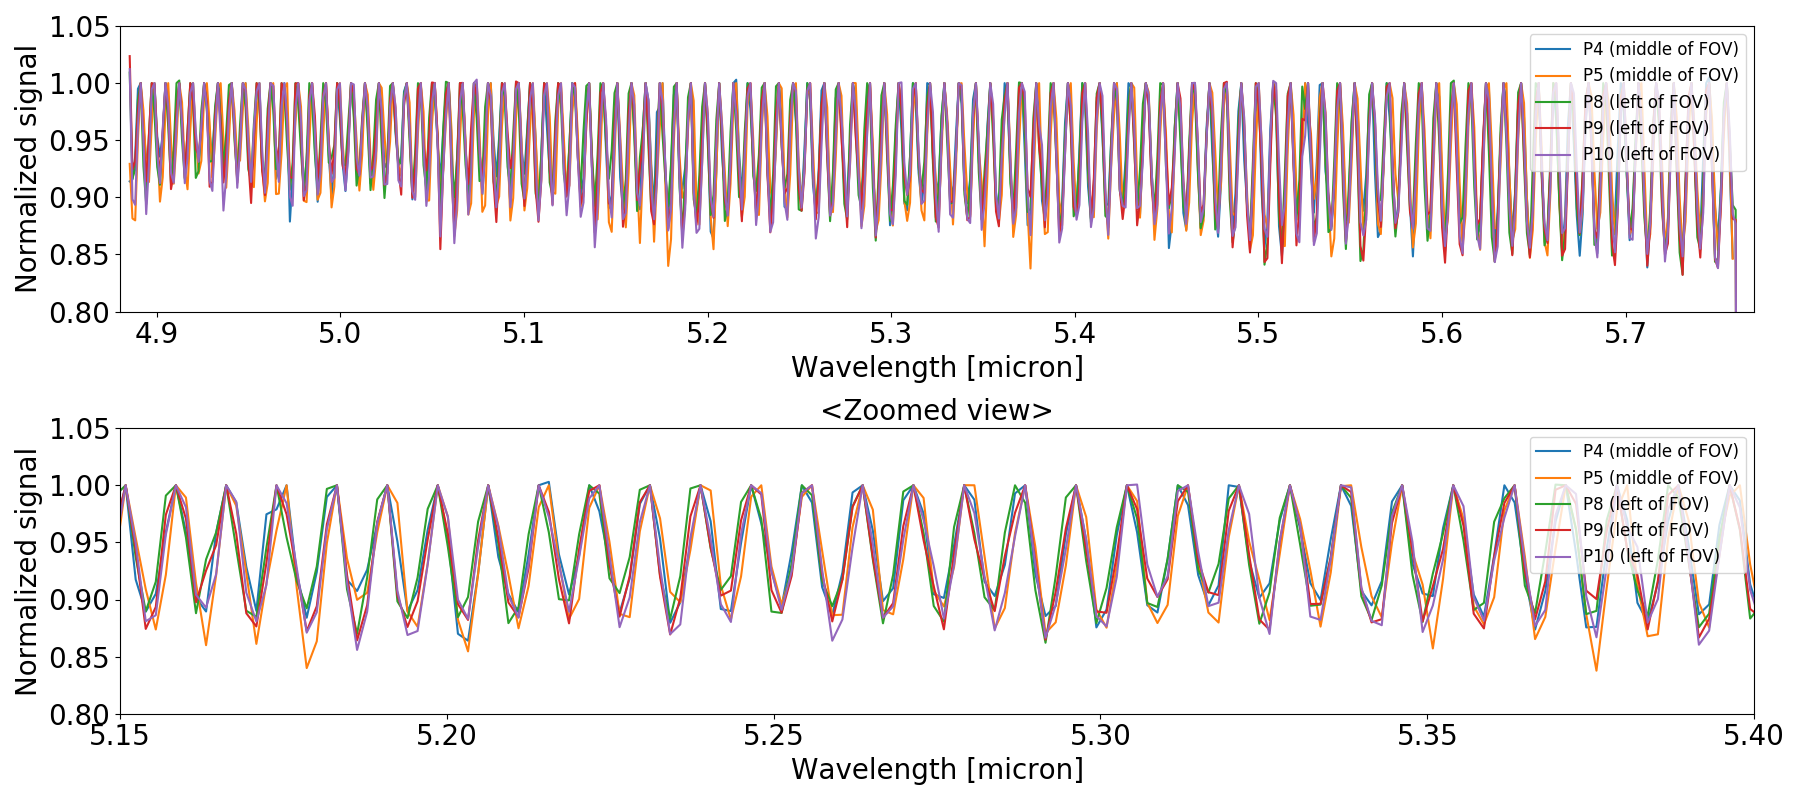

In [33]:
fig,axs = plt.subplots(2,1,figsize=(18,8))
for plot in range(2):
    for pointing in ['P4','P5']:
        axs[plot].plot(lambcens,pointsource_middleraster_centroids[pointing][0]/pointsource_middleraster_norm[pointing][2],label=pointing+' (middle of FOV)')
    for pointing in ['P8','P9','P10']:
        axs[plot].plot(lambcens,pointsource_leftraster_centroids[pointing][0]/pointsource_leftraster_norm[pointing][2],label=pointing+' (left of FOV)')
    axs[plot].set_ylim(0.8,1.05)
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Normalized signal')
    axs[plot].legend(loc='upper right',fontsize=12)
axs[0].set_xlim(4.88,5.77)
axs[1].set_xlim(5.15,5.40)
axs[1].set_title('<Zoomed view>')
plt.tight_layout()

### Remarks:
* Within the boundaries of the remarks made so far (in the independent study of the left side and middle of the FOV), there is general agreement between the fringe profiles.
  
Let's perform the across-slice analysis one last time for the right side of the FOV. There is no raster scan observation in slice 10 on the right side of the FOV, and only one in slice 11 and slice 12. We thus examine slice 13 (remember that there is a wavelength error /offset between slices 1-11 and 12-21, thus a fringe profile comparison is not possible without introducing an important error).

In [ ]:
# centroiding process for the point sources on the right side of the FOV
pointsource_rightraster_centroids = {}
for pointing in ['P3','P4']:
    point_source_sci_p,point_source_bkg_p        = mrsobs.FM_MTS_800K_BB_MRS_OPT_06_raster(lvl2path,position='right',pointing=pointing)
    point_source_p_bkgsubtr                      = point_source_sci_p-point_source_bkg_p
    point_source_p_oddevencorr                   = funcs.OddEvenRowSignalCorrection(point_source_p_bkgsubtr)
    pointsource_rightraster_centroids[pointing] = funcs.point_source_centroiding(point_source_p_oddevencorr,band,d2cMaps,spec_grid=[lambcens,lambfwhms],fit='1D') # let's look at the result for the point sources

<IPython.core.display.Javascript object>


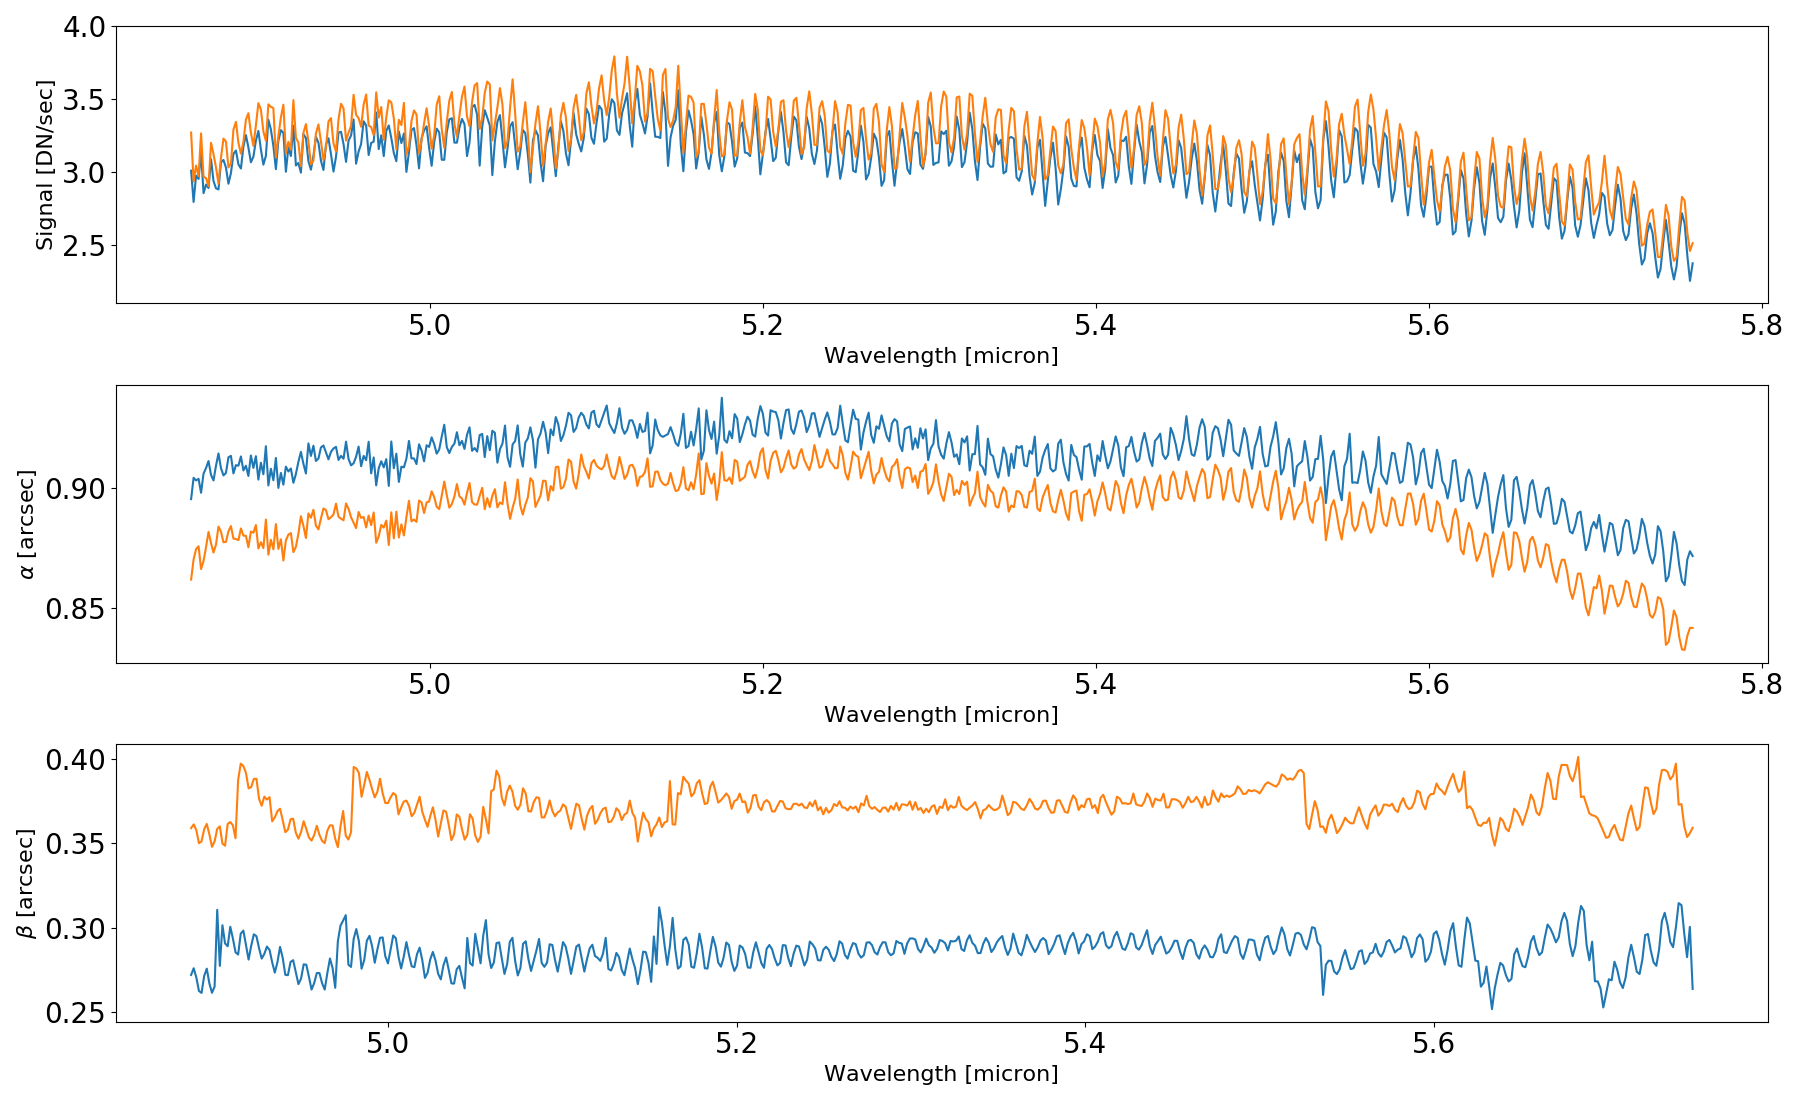

In [36]:
fig,axs = plt.subplots(3,1,figsize=(18,11))
for pointing in ['P3','P4']:
    axs[0].plot(lambcens,pointsource_rightraster_centroids[pointing][0])
    axs[1].plot(lambcens,pointsource_rightraster_centroids[pointing][1])
    axs[2].plot(lambcens,pointsource_rightraster_centroids[pointing][2])
axs[0].set_ylim(2.1,4)
axs[0].set_ylabel(r'Signal [DN/sec]',fontsize=16)
axs[1].set_ylabel(r'$\alpha$ [arcsec]',fontsize=16)
axs[2].set_ylabel(r'$\beta$ [arcsec]',fontsize=16)
for plot in range(3):
    axs[plot].set_xlabel('Wavelength [micron]',fontsize=16)
plt.tight_layout()

In [37]:
pointsource_rightraster_norm = {}
for pointing in ['P3','P4']:
    pointsource_rightraster_norm[pointing] = funcs.norm_fringe(pointsource_rightraster_centroids[pointing][0],thres=0,min_dist=2,k=3,ext=3)

<IPython.core.display.Javascript object>


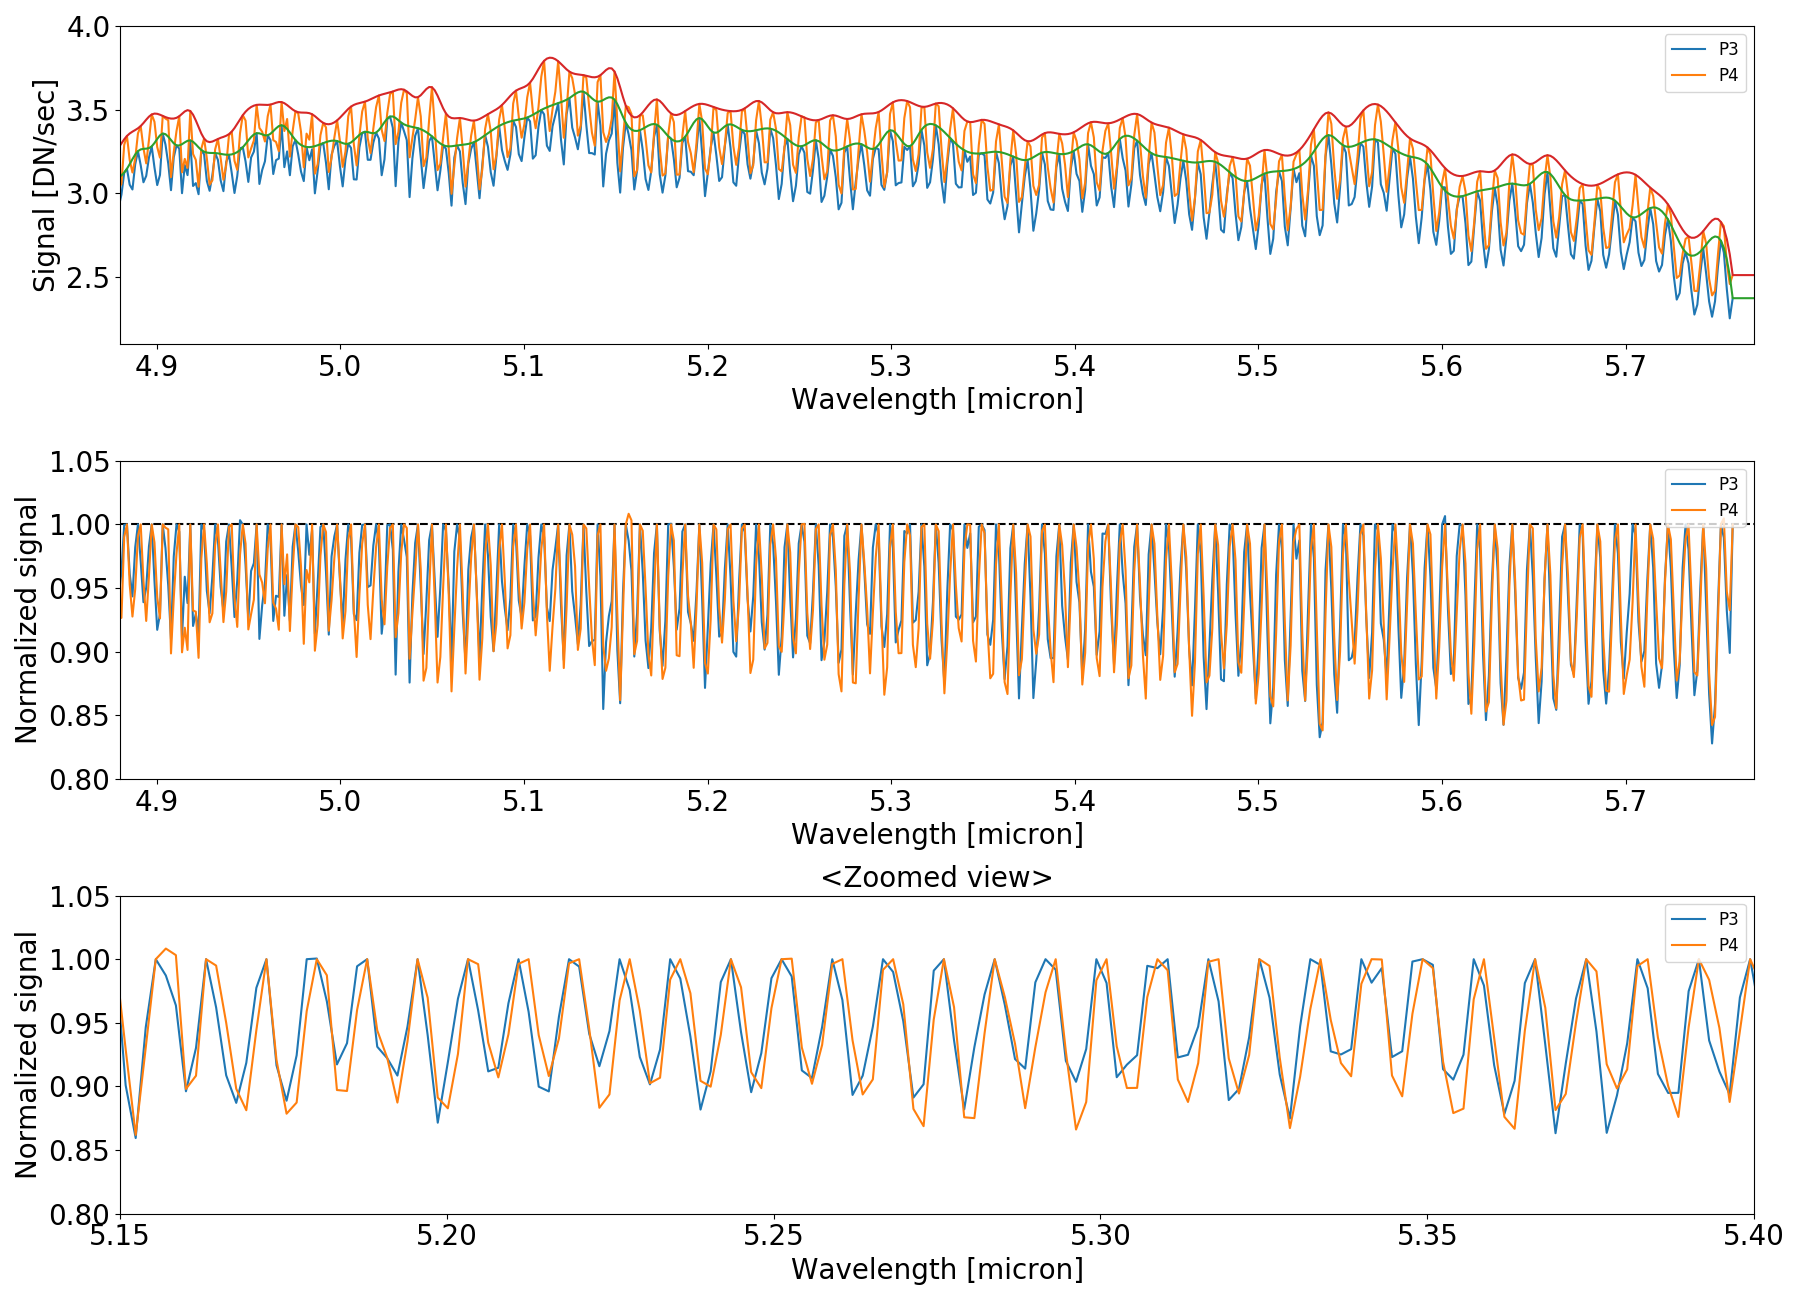

In [38]:
# let's look at the results
fig,axs = plt.subplots(3,1,figsize=(18,13))
for pointing in ['P3','P4']:
    axs[0].plot(lambcens,pointsource_rightraster_centroids[pointing][0],label=pointing)
for pointing in ['P3','P4']:
    axs[0].plot(lambcens,pointsource_rightraster_norm[pointing][2])
    axs[1].plot(lambcens,pointsource_rightraster_centroids[pointing][0]/pointsource_rightraster_norm[pointing][2],label=pointing)
    axs[2].plot(lambcens,pointsource_rightraster_centroids[pointing][0]/pointsource_rightraster_norm[pointing][2],label=pointing)
axs[0].set_ylim(2.1,4)
axs[0].set_ylabel('Signal [DN/sec]')
axs[1].hlines(1,4.88,5.77,linestyle='dashed')
for plot in range(2):
    axs[plot].set_xlim(4.88,5.77)
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].legend(loc='upper right',fontsize=12)
for plot in range(1,3):
    axs[plot].set_ylim(0.8,1.05)
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Normalized signal')
    axs[plot].legend(loc='upper right',fontsize=12)
axs[2].set_xlim(5.15,5.40)
axs[2].set_title('<Zoomed view>')
plt.tight_layout()

<IPython.core.display.Javascript object>


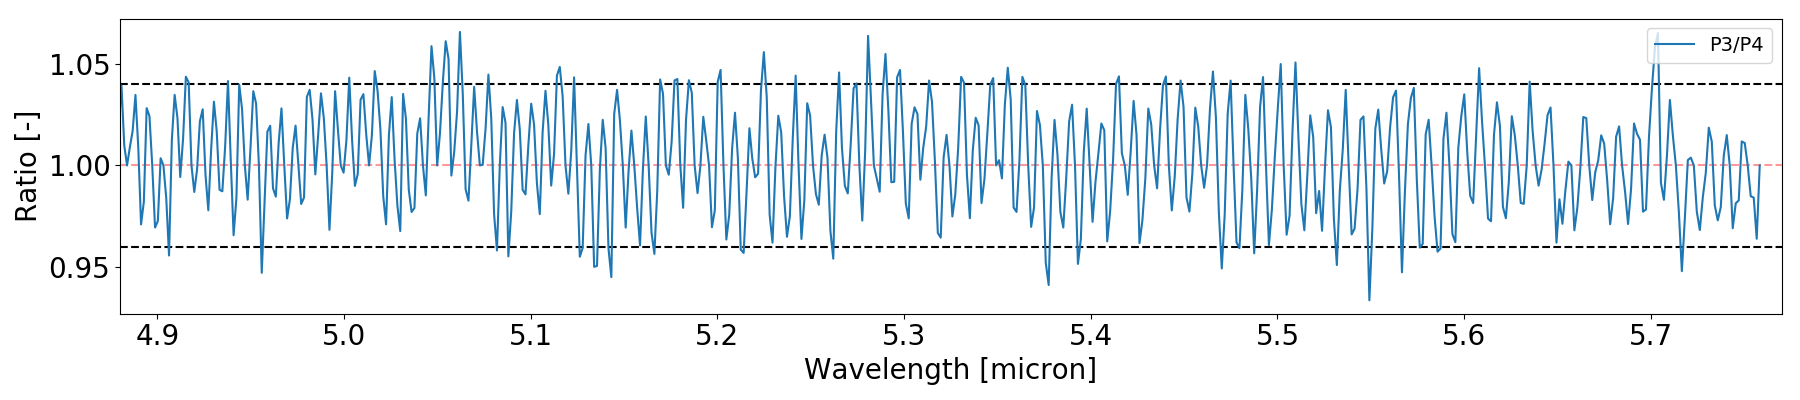

In [39]:
p3 = pointsource_rightraster_centroids['P3'][0]/pointsource_rightraster_norm['P3'][2]
p4 = pointsource_rightraster_centroids['P4'][0]/pointsource_rightraster_norm['P4'][2]

plt.figure(figsize=(18,4))
plt.plot(lambcens,p3/p4,label='P3/P4')
plt.hlines([0.96,1.04],4.88,5.77,linestyle='dashed')
plt.hlines(1,4.88,5.77,'r',alpha=0.4,linestyle='dashed')
plt.xlim(4.88,5.77)
plt.xlabel('Wavelength [micron]')
plt.ylabel('Ratio [-]')
plt.legend(loc='upper right',fontsize=14)
plt.tight_layout()

<IPython.core.display.Javascript object>


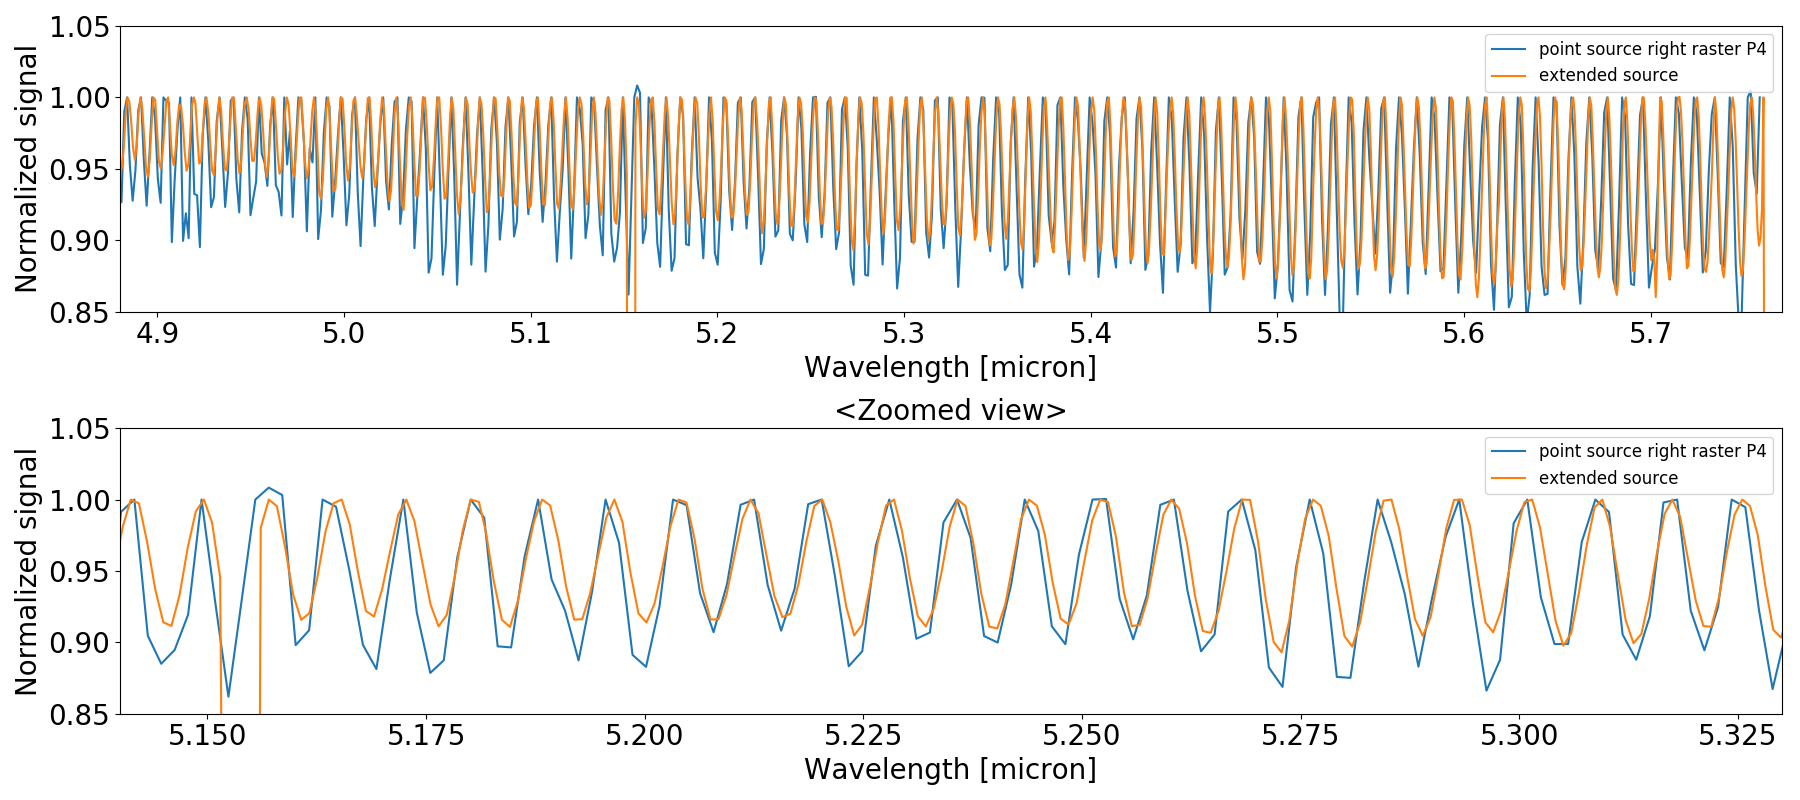

In [41]:
point_source_sci_p4,point_source_bkg_p4 = mrsobs.FM_MTS_800K_BB_MRS_OPT_06_raster(lvl2path,position='right',pointing='P4')
point_source_p4_bkgsubtr                = point_source_sci_p4-point_source_bkg_p4
point_source_p4_oddevencorr             = funcs.OddEvenRowSignalCorrection(point_source_p4_bkgsubtr)
ypos_p4,xpos_p4                         = funcs.detpixel_trace_compactsource(point_source_p4_oddevencorr,band,d2cMaps)

extsource_p4_norm = funcs.norm_fringe(ext_source_oddevencorr[ypos_p4,xpos_p4],thres=0,min_dist=6,k=3,ext=3)

# let's look at the results
fig,axs = plt.subplots(2,1,figsize=(18,8))
for i in [0,1]:
    axs[i].plot(lambcens,p4,label='point source right raster P4')
    axs[i].plot(lambdaMap[ypos_p4,xpos_p4],extsource_p4_norm[0]/extsource_p4_norm[2],label='extended source')
    axs[i].set_ylim(0.85,1.05)
    axs[i].set_xlabel('Wavelength [micron]')
    axs[i].set_ylabel('Normalized signal')
    axs[i].legend(loc='upper right',fontsize=12)
axs[0].set_xlim(4.88,5.77)
axs[1].set_xlim(5.14,5.33)
axs[1].set_title('<Zoomed view>')
plt.tight_layout()

### Remarks:
* The drawn conclusions are once again of a similar nature to the two previous cases (seemingly erratic amplitude differences, and small frequency and/or phase offset).

## Conclusions:  
* The pixel sampling of the MRS makes it difficult to study point source fringes without some kind of spatial fitting.
* The fringe profile of a point source can be extracted by fitting the PSF with a 1D Gaussian in every spectral bin on the detector and taking the Gaussian peak in every bin.
* Looking at different across-slice positions of a point source, and dividing the fringe profiles, yields periodic residuals of 4%. This could be due to a wavelength offset in across-slice direction.
* There is a clear disagreement between the point source fringes and the extended source fringes. The disagreement in frequency and/or phase appears to be consistent in different along-slice positions. The disagreement in amplitude however varies in an (as of yet) unpredictable manner.


## Follow-up question:  
In this notebook we only looked at the peak intensity of the point sources (peak of the PSF). How does the fringe transmission change at different locations on the PSF (if at all)?